In [1]:
import os
from pybedtools import BedTool
import pandas as pd
import seaborn as sns
from plot_params import *

indir1 = '/home/hsher/scratch/circ_nextera_iter12/output/'
circ_quant_output = [os.path.join(indir1,f) for f in os.listdir(indir1) if f.endswith('.gtf')]

# the basic rar11 recipe
indir = '/home/hsher/scratch/circ_nextera_iter2/output/'
circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf') 
                      and f.startswith('HEK_rar11')]

indir3 = '/home/hsher/scratch/circ_nextera/output/'
circ_quant_output += [os.path.join(indir3,f) for f in os.listdir(indir3) if f.endswith('.gtf') 
                      and f.startswith('circseq-bm-rar11-nxt')]

indir4 = '/projects/ps-yeolab3/tao/CIRI/organoids/output'
circ_quant_output += [os.path.join(indir4,f) for f in os.listdir(indir4) if f.endswith('.gtf')]



In [2]:
circ_quant_output

['/home/hsher/scratch/circ_nextera_iter12/output/K562_rep2_rar11.gtf',
 '/home/hsher/scratch/circ_nextera_iter12/output/K562_rep1_rar11.gtf',
 '/home/hsher/scratch/circ_nextera_iter12/output/HepG2_rep2_rar11.gtf',
 '/home/hsher/scratch/circ_nextera_iter12/output/HeLa_rep1_rar11.gtf',
 '/home/hsher/scratch/circ_nextera_iter12/output/HepG2_rep1_rar11.gtf',
 '/home/hsher/scratch/circ_nextera_iter12/output/HeLa_rep2_rar11.gtf',
 '/home/hsher/scratch/circ_nextera_iter2/output/HEK_rar11.gtf',
 '/home/hsher/scratch/circ_nextera/output/circseq-bm-rar11-nxt.gtf',
 '/projects/ps-yeolab3/tao/CIRI/organoids/output/CVB_STO.gtf',
 '/projects/ps-yeolab3/tao/CIRI/organoids/output/HT_109_STO_2.gtf',
 '/projects/ps-yeolab3/tao/CIRI/organoids/output/HT_109_CO.gtf',
 '/projects/ps-yeolab3/tao/CIRI/organoids/output/HT_109_STO_1.gtf']

In [3]:
def read_ciri_gtf(fname):
    bed = BedTool(fname)
    df = bed.to_dataframe()
    # filter for non-entries
    stat = df.loc[df['seqname'].str.contains('##'), 'seqname'].str.split(': ', expand = True)
    df = df.loc[~df['seqname'].str.contains('##')].reset_index()
    
    # get attributes
    attrs = pd.DataFrame([i.attrs for i in bed])
    
    return pd.concat([df, attrs], axis = 1), stat

In [4]:
circ_type_count = []
names = []
junc_ratio_tbl = []
bsj_ratio_tbl = []
fsj_ratio_tbl = []
stats = []
mega_anno = []

features = ['seqname', 'start', 'end', 
       'strand', 'circ_type', 'gene_id', 'gene_name', 'gene_type']

for fname in circ_quant_output:
    name = os.path.basename(fname).replace('.gtf', '')
    names.append(name)
    
    circ_df, stat = read_ciri_gtf(fname)
    
    circ_type_count.append(circ_df['circ_type'].value_counts())
    
    junc_ratio_tbl.append(circ_df.set_index('circ_id')['junc_ratio'].astype(float))
    bsj_ratio_tbl.append(circ_df.set_index('circ_id')['bsj'].astype(float))
    fsj_ratio_tbl.append(circ_df.set_index('circ_id')['fsj'].astype(float))
    stats.append(stat.set_index(0))
    mega_anno.append(circ_df.set_index('circ_id')[features])
mega_anno = pd.concat(mega_anno, axis = 0).drop_duplicates()

# basic stats
stats_df = pd.concat(stats, axis = 1).T
for col in ['##Total_Reads', '##Mapped_Reads', '##Circular_Reads']:
    stats_df[col] = stats_df[col].astype(int)
stats_df['frac_circular'] = stats_df['##Circular_Reads']/stats_df['##Mapped_Reads']
stats_df['frac_mapped'] = stats_df['##Mapped_Reads']/stats_df['##Total_Reads']
stats_df.sort_values('frac_circular')
stats_df.set_index('##Sample', inplace = True)

# counts
counts = pd.concat(circ_type_count, axis = 1)
counts.columns = names

bsj = pd.concat(bsj_ratio_tbl, axis = 1)
bsj.columns = names

fsj = pd.concat(fsj_ratio_tbl, axis = 1)
fsj.columns = names

junc = pd.concat(junc_ratio_tbl, axis = 1)
junc.columns = names

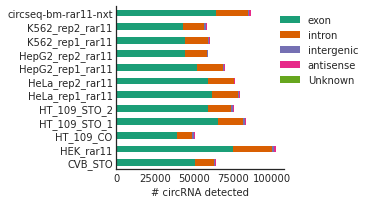

In [5]:
import matplotlib.pyplot as plt
counts.T.sort_index().plot.barh(stacked = True, figsize = (3,3))
plt.xlabel('# circRNA detected')
plt.legend(bbox_to_anchor = (1.5, 1))
sns.despine()


/home/hsher/miniconda3/envs/Metadensity/lib/python3.9/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


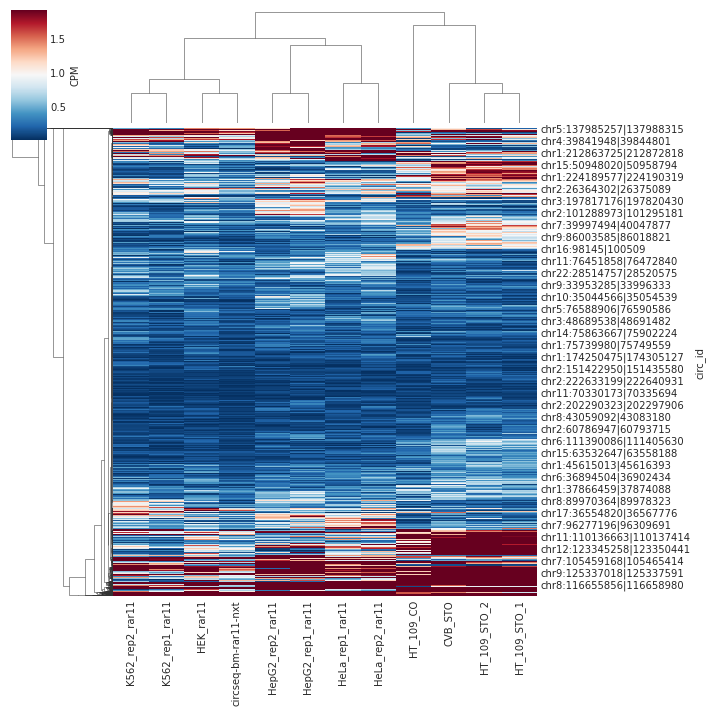

In [6]:
# compare CPM
cpm=bsj.div(stats_df['##Total_Reads'], axis = 1)*10**6
all_expressed = cpm.loc[cpm.isnull().sum(axis = 1)<1]
max_value = all_expressed.mean().median()
sns.clustermap(all_expressed, cmap = 'RdBu_r', vmax = max_value*2, 
              cbar_kws = {'label':'CPM'})
plt.savefig(figdir / '5_organoid_cline_CPM_clust.pdf')

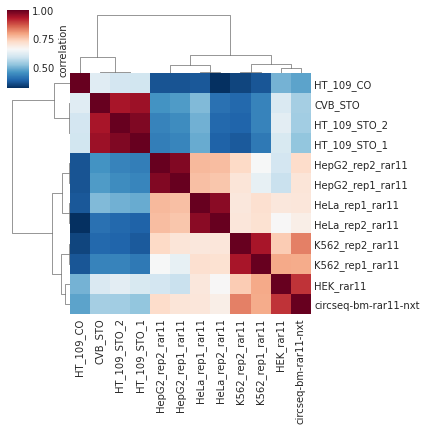

In [7]:
from scipy.spatial.distance import pdist, squareform
corr = pd.DataFrame(1-squareform(pdist(all_expressed.T, 'correlation')),
                    index = all_expressed.columns,
                    columns = all_expressed.columns)

sns.clustermap(corr, metric = 'correlation', cmap = 'RdBu_r', figsize = (6,6), cbar_kws = {'label': 'correlation'})
plt.savefig(figdir / '5_organoid_cline_CPM_corr.pdf')